In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit
from ase.units import kB

# Initial configuration

In [2]:
# random choice among [0,1,2]
def random_initial_state(N):
  config = np.random.choice(list(range(len(J))), size=(N, N))
  return config

# Fixing molar fraction (Xi)
# (X0, X1, X2) = (133, 133, 134)
# grid = np.array(X0*[0]+X1*[1]+X2*[2])
# np.random.shuffle(grid)
# grid = grid.reshape((N,N))

In [3]:
@njit
def calculate_energy(config, J):
    energy = 0
    for i in range(N):
        for j in range(N):
            for di, dj in [(1, 0), (0, 1), (-1, 0), (0, -1)]: # square lattice
                ni, nj = (i + di) % N, (j + dj) % N
                energy += J[config[i, j], config[ni, nj]]
    return energy / 2.

@njit
def calculate_warrencowley(config, J):
    """Calculate the Warren-Cowley parameters to measure the short-range order (SRO) in alloys."""
    N = config.shape[0] # Number of points in grid
    E = len(J) # Number of element types
    count = np.zeros(E)
    occurrence = np.zeros((E,E))
    
    for i in range(N):
        for j in range(N):
            current_type = config[i, j]
            count[config[i, j]] += 1
            for di, dj in [(1,0), (0,1), (-1,0), (0,-1)]:
                ni, nj = (i + di) % N, (j + dj) % N
                neighbor_type = config[ni, nj]
                occurrence[current_type, neighbor_type] += 1

    coordination_number = 4
    normalization = np.where(count > 0, count, 1)
    normalized_prob = occurrence.T / (coordination_number*normalization)

    identity = np.identity(E)
    alpha = identity - normalized_prob.T
    return alpha

def calculate_omega(alpha):
    n = len(alpha)
    upper_triangle = np.triu(alpha**2, k=1)
    sum_upper = np.sum(upper_triangle)
    return np.sqrt(sum_upper/(n*(n-1)/2))

@njit
def mc_move(config, beta, J):
    """Perform Monte Carlo moves with the constraint of equal numbers of up and down spins."""
    N = config.shape[0]
    for _ in range(N*N):
        # Save original configuration
        original_config = np.copy(config)

        # Selecting spins to swap
        i1, j1 = np.random.randint(0, N, size=2)
        i2, j2 = np.random.randint(0, N, size=2)
        while (i1, j1) == (i2, j2):  # Ensure they are different
            i2, j2 = np.random.randint(0, N, size=2)
                
        # Swap the spins
        config[i1, j1], config[i2, j2] = config[i2, j2], config[i1, j1]
        
        delta_E = calculate_energy(config, J) - calculate_energy(original_config, J)
        
        if delta_E > 0 and np.random.rand() >= np.exp(-delta_E * beta):
            # Revert the swap if the move is not energetically favorable
            config[...] = original_config

def ising_model(N=10, mc_steps=500, T=1.0, J=np.identity(3), initial_state=None):
    if (initial_state.all()==None):
        config = random_initial_state(N)
    else:
        config = initial_state
    
    beta = 1.0 / T
    for _ in tqdm(range(mc_steps), desc="inner loop", position=1, leave=False):
        mc_move(config, beta, J)

    energy = calculate_energy(config, J)
    return config, energy


In [4]:
# Parameters
N = 80  # Dimensions of the grid (NxN)

# Interaction matrix
              # Co,   Cr,   Ni
# J = np.array([[ 0.00,-0.12, 0.00],  # Co
#               [-0.19, 0.00,-0.08],  # Cr
#               [ 0.00,-0.05, 0.00]]) # Ni

J = np.array([[ 0.00, 0.10, 0.20],  # Co
              [ 0.10, 0.00, 0.05],  # Cr
              [ 0.20, 0.05, 0.00]]) # Ni


J = (J + J.T)/2 # Symmetrization

initial_config = np.copy(random_initial_state(N))

mc_steps = 400
configs = []
energies = []
alphas = []

temp_step = 50
temperatures = np.arange(200,1501,temp_step)

for T in tqdm(temperatures, desc="outer loop", position=0):
    config, energy = ising_model(N, mc_steps, kB*T, J, initial_config)
    final_config = np.copy(config)
    alpha = calculate_warrencowley(final_config, J).ravel()
    initial_state = np.copy(final_config)
    configs.append(final_config)
    energies.append(energy)
    alphas.append(alpha)
    


outer loop: 100%|██████████| 27/27 [39:03<00:00, 86.79s/it]


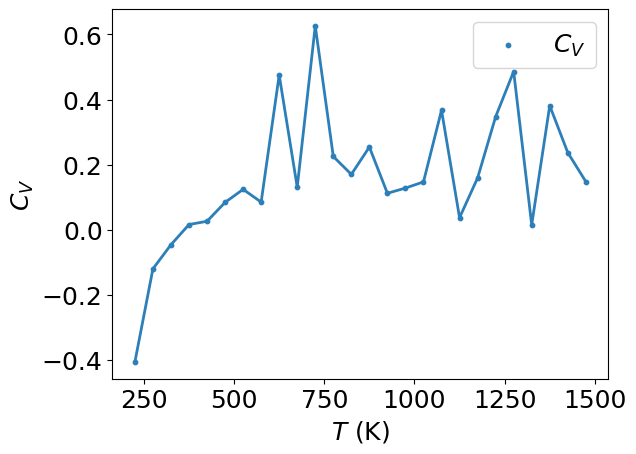

In [5]:
temp_mean = (temperatures[:-1] + temperatures[1:])/2

cv = np.diff(energies)/temp_step
plt.plot(temp_mean, cv, color='#2c7fb8', linestyle='-', linewidth=2)
plt.scatter(temp_mean, cv, color='#2c7fb8', s=10, label='$C_{V}$')
plt.legend(fontsize=18, loc="upper right")
plt.xlabel('$T$ (K)', fontsize=18)  
plt.ylabel('$C_{V}$', fontsize=18) 
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

In [6]:
alpha_CoCr = [alphas[i][1] for i in range(len(alphas))]
alpha_CoNi = [alphas[i][2] for i in range(len(alphas))]
alpha_CrNi = [alphas[i][5] for i in range(len(alphas))]

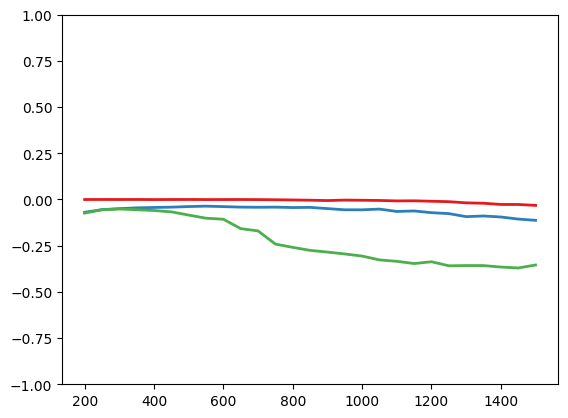

In [7]:
plt.plot(temperatures, alpha_CoCr, color='#2c7fb8', linestyle='-', linewidth=2, label='CoCr')
plt.plot(temperatures, alpha_CoNi, color='#e41a1c', linestyle='-', linewidth=2, label='CoNi')
plt.plot(temperatures, alpha_CrNi, color='#4daf4a', linestyle='-', linewidth=2, label='CrNi')
plt.ylim(-1,1)
plt.show()

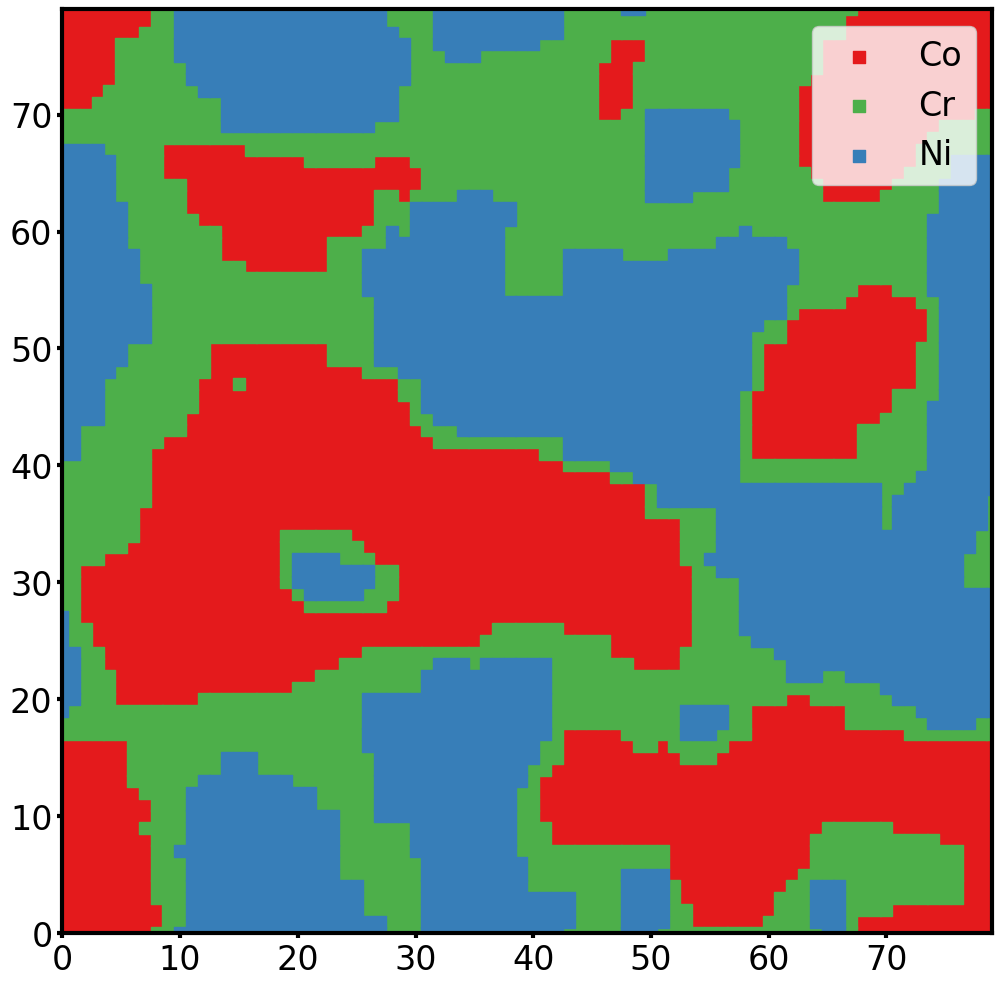

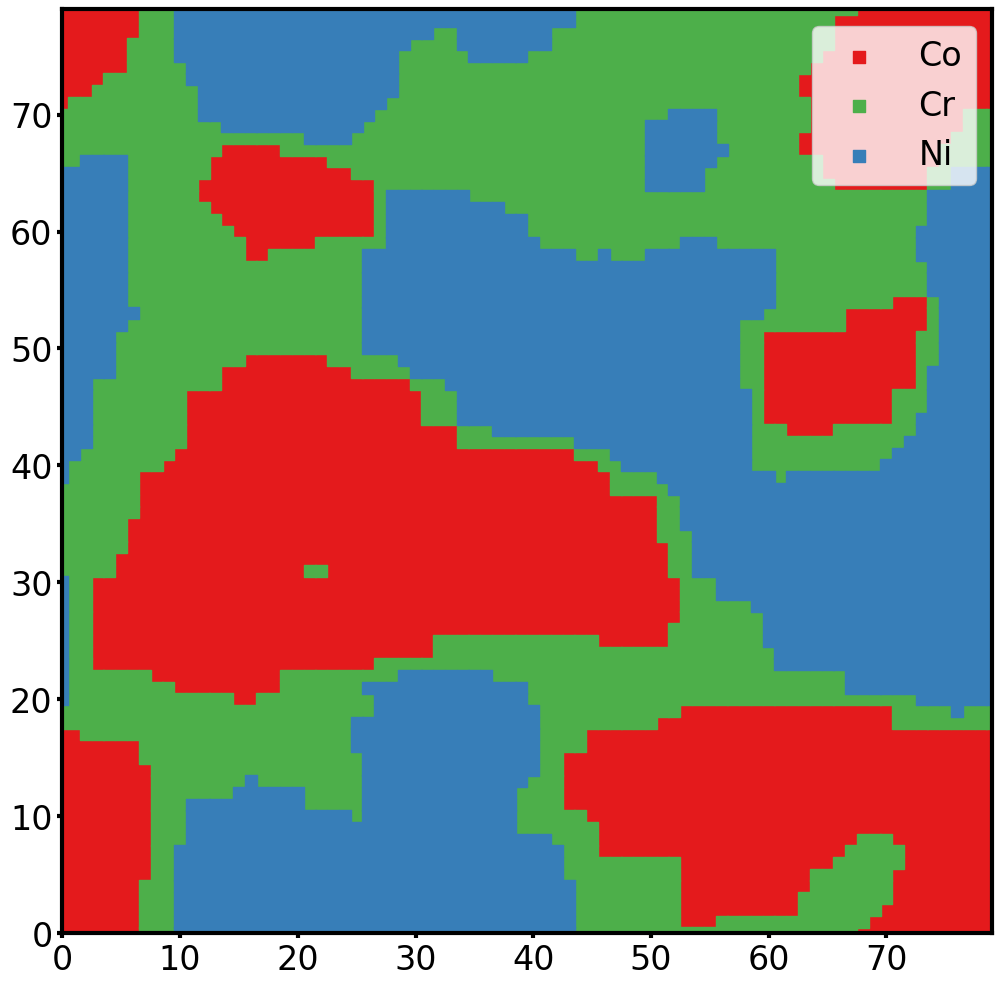

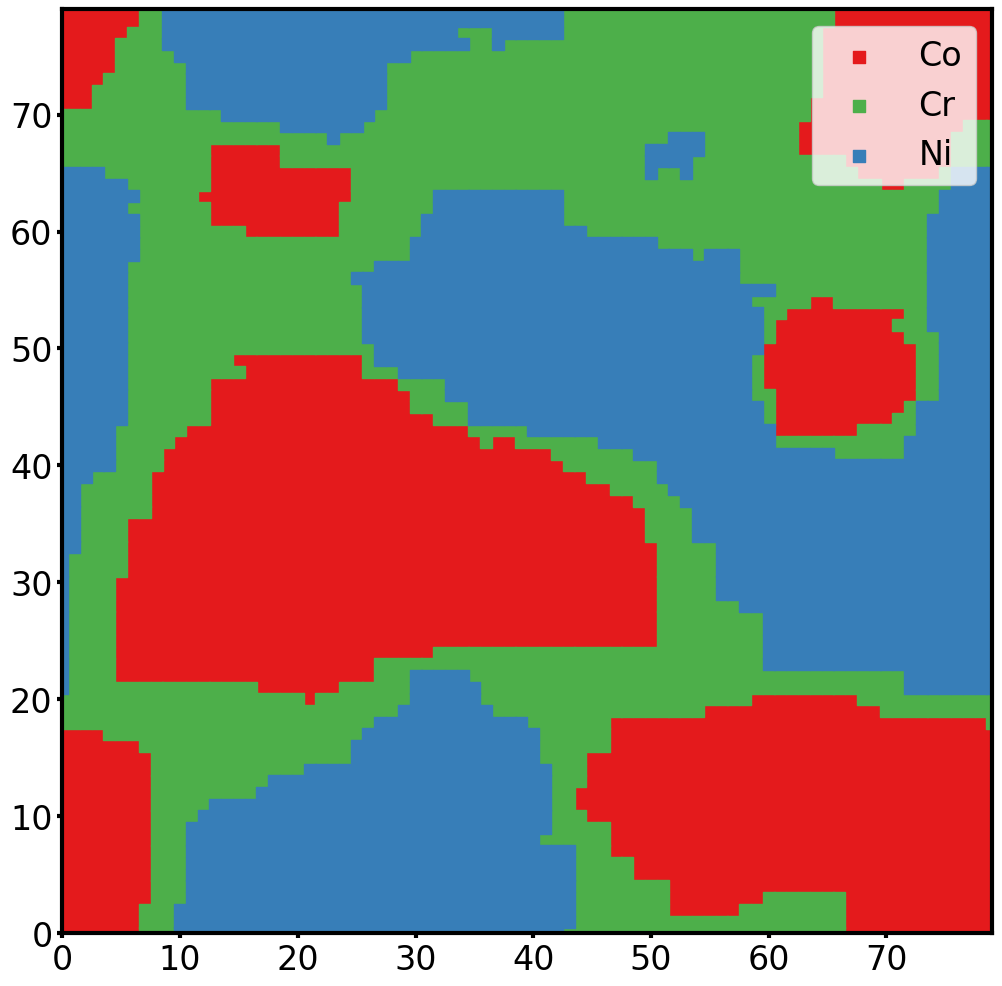

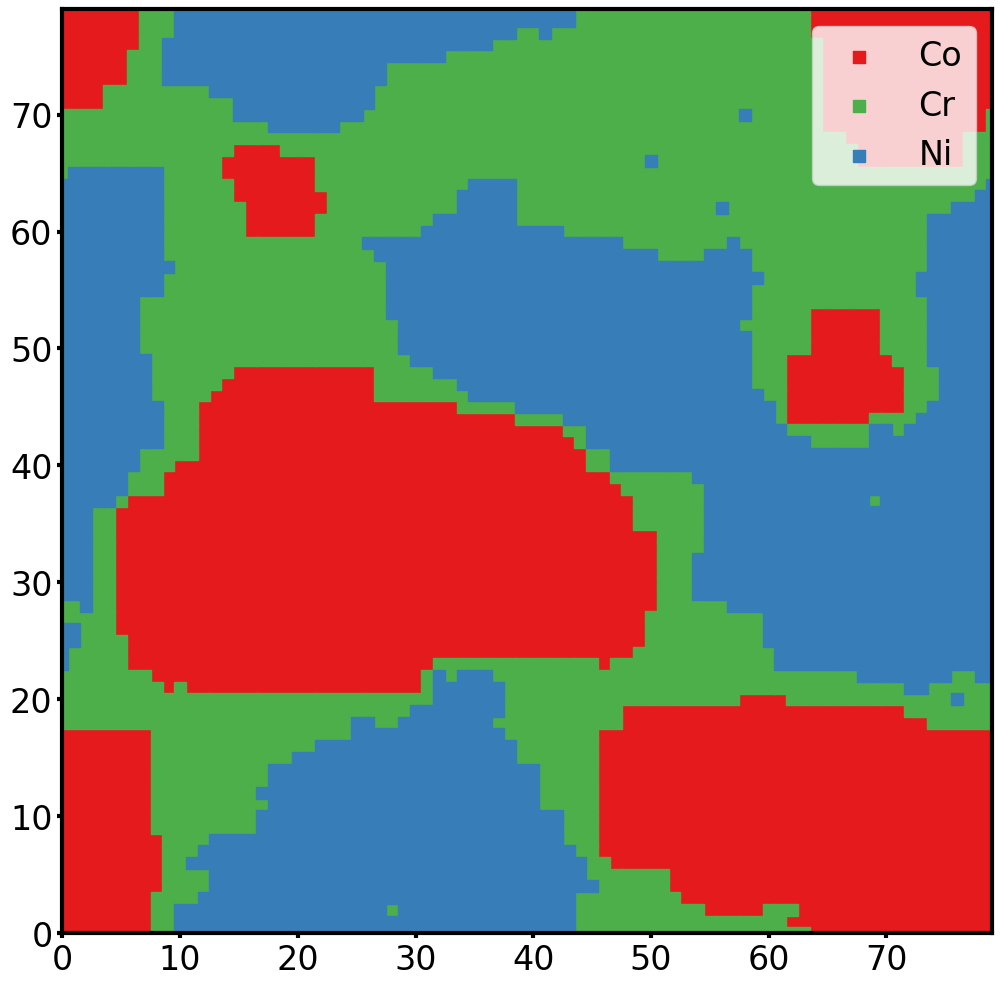

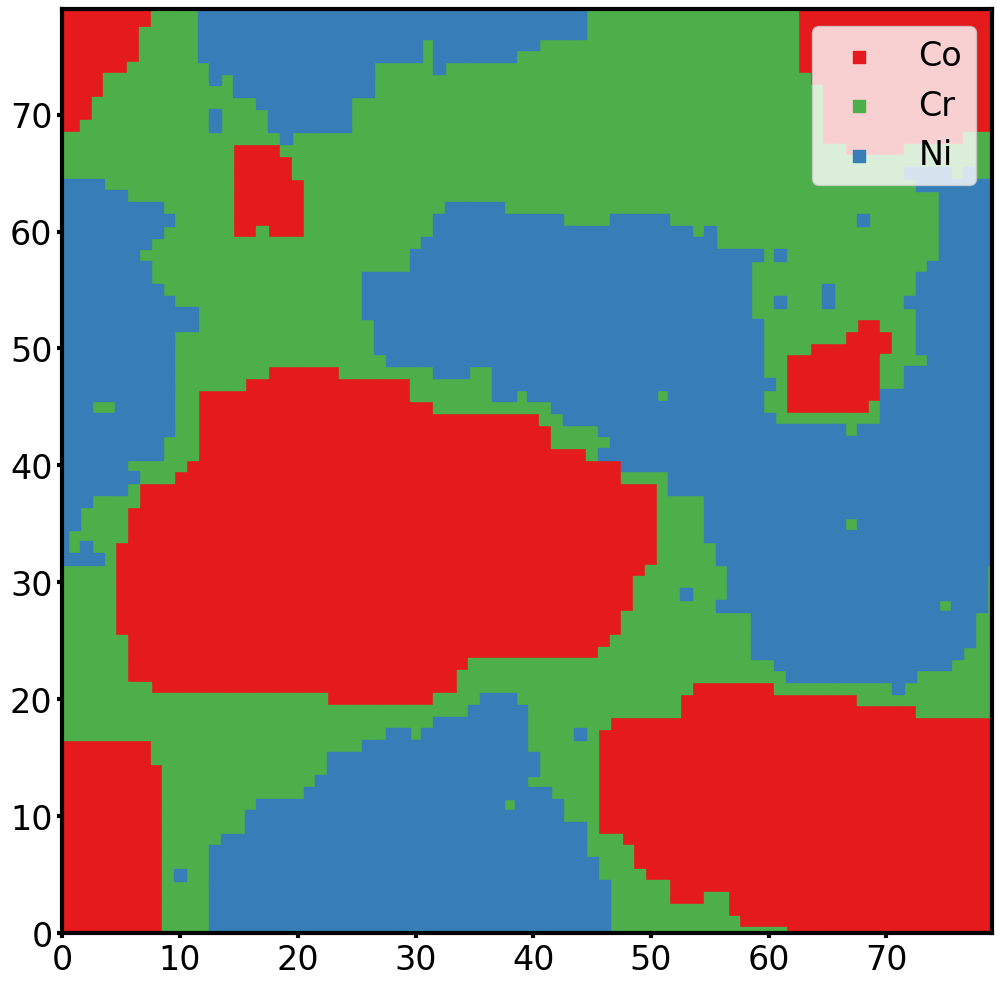

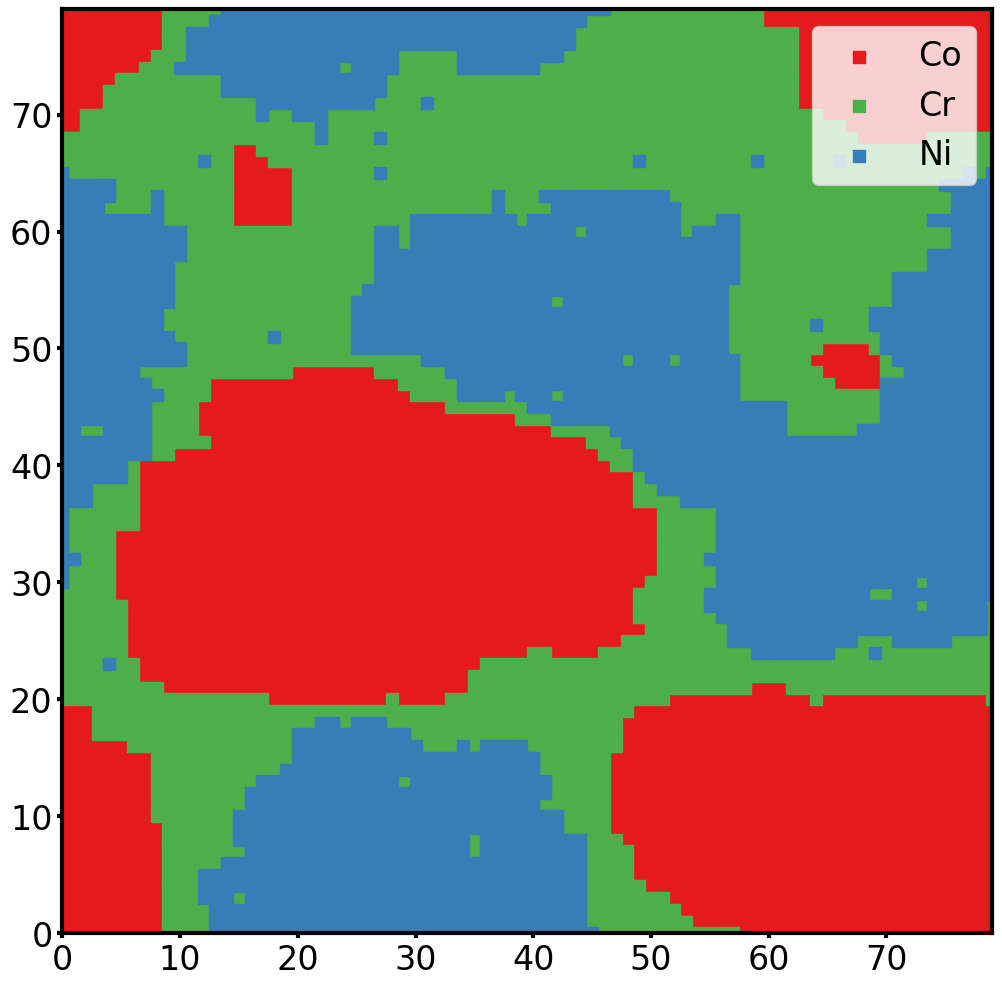

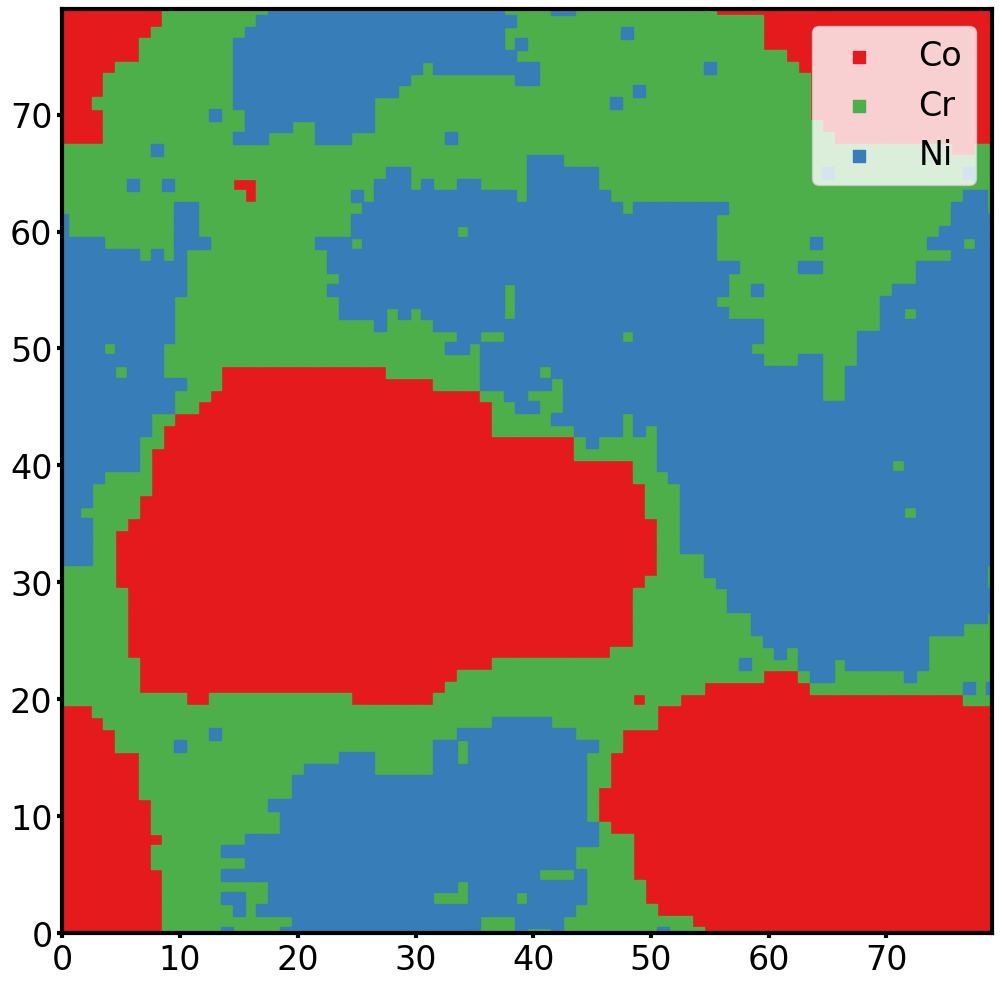

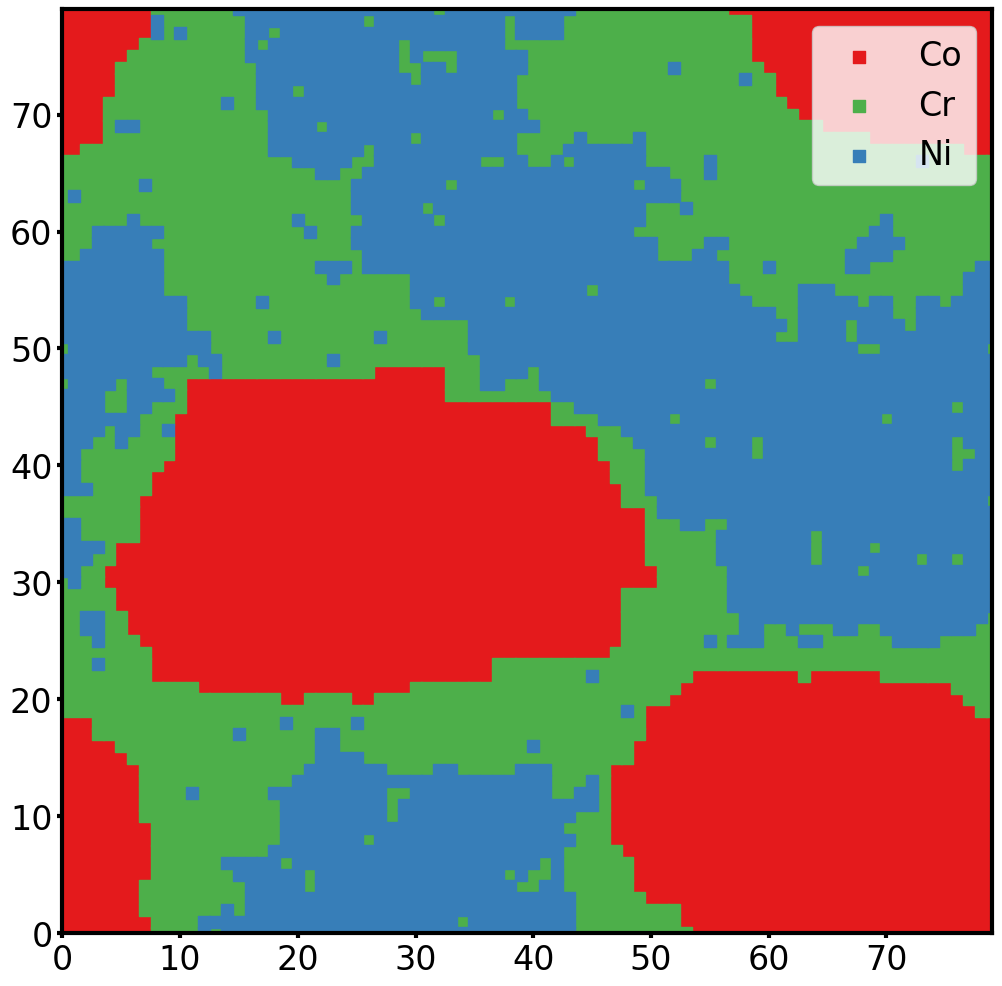

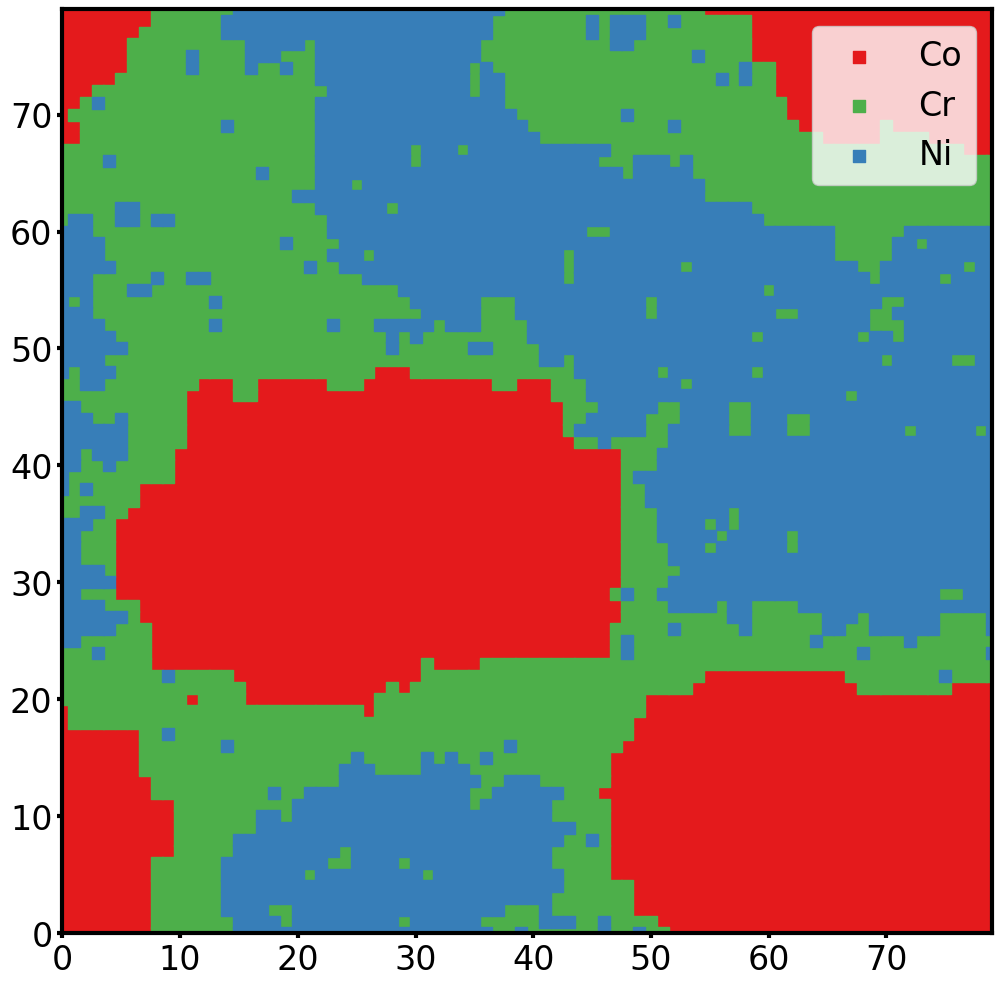

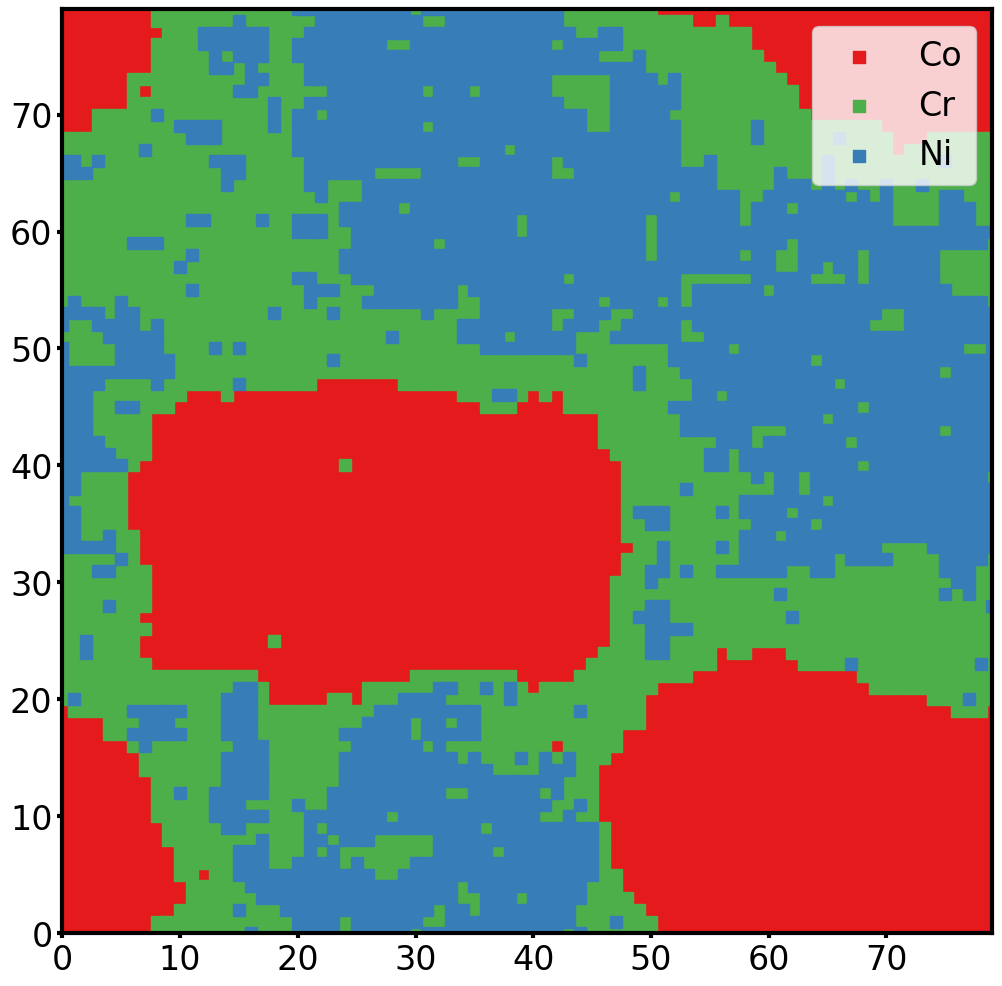

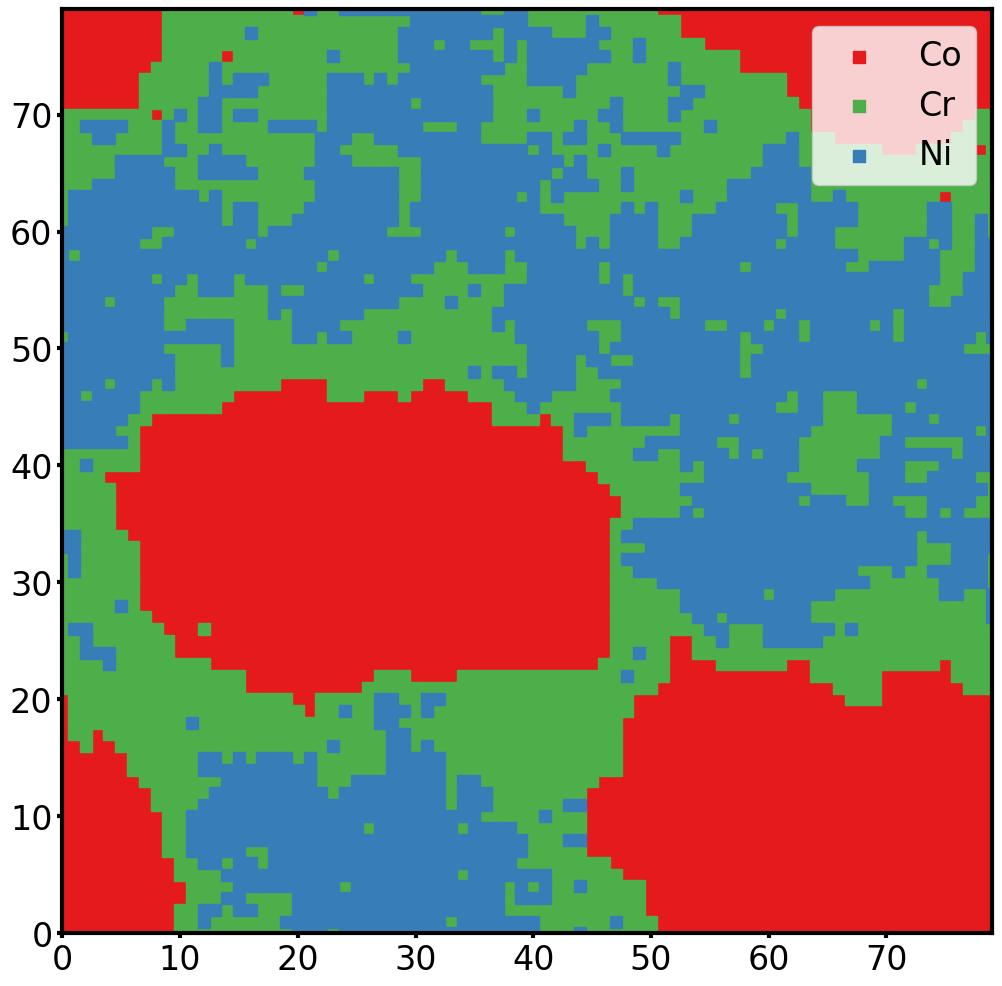

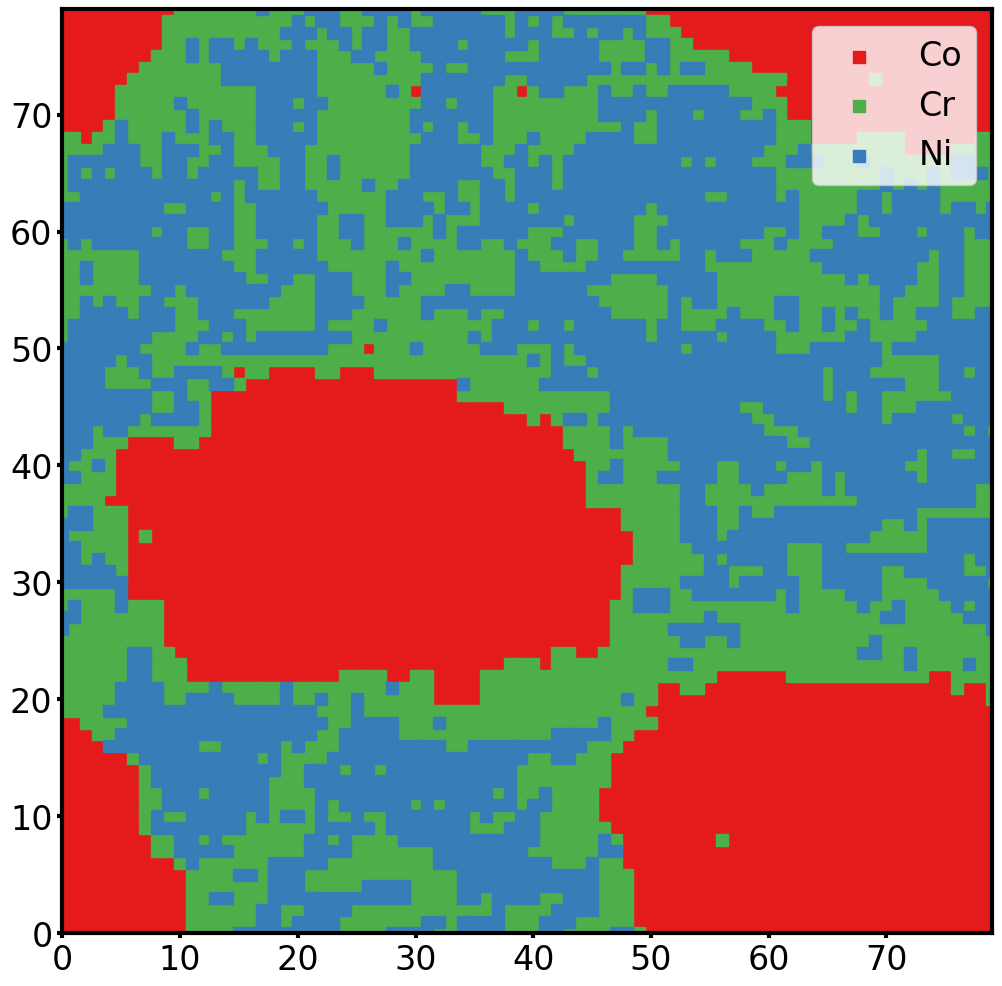

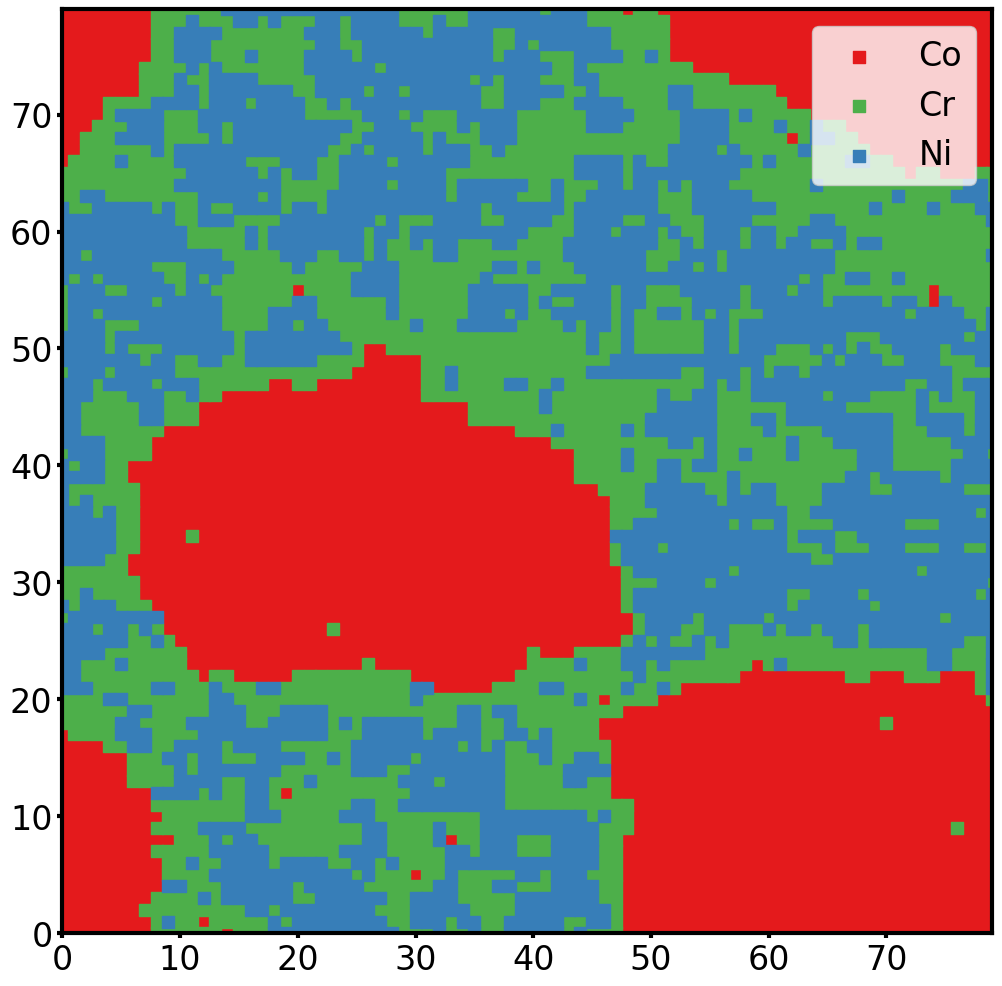

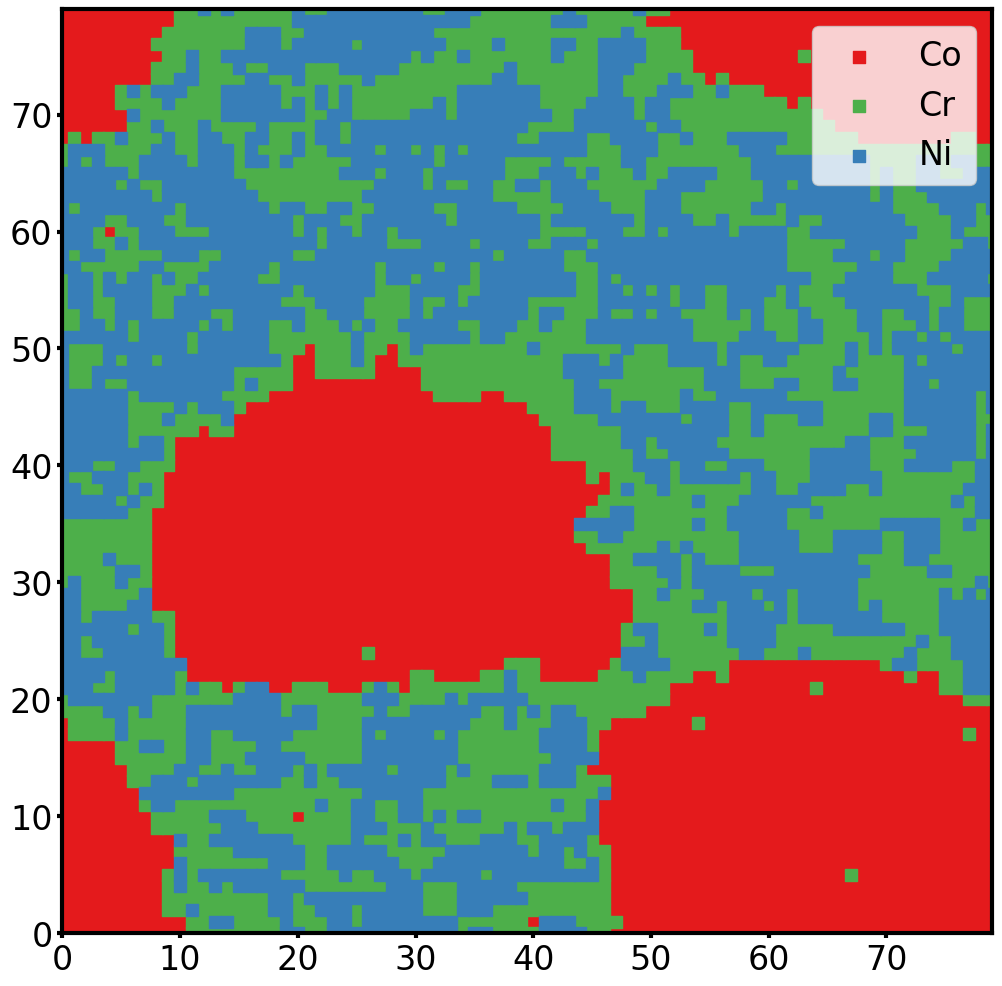

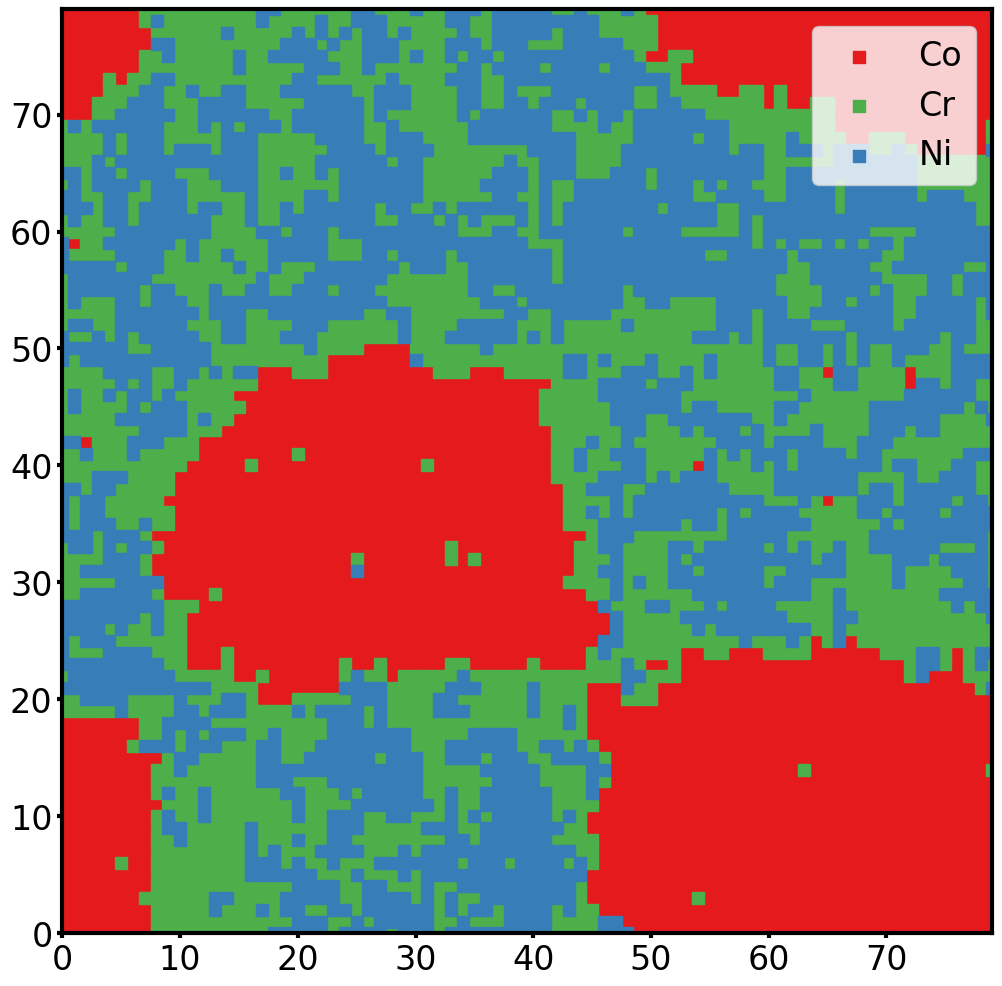

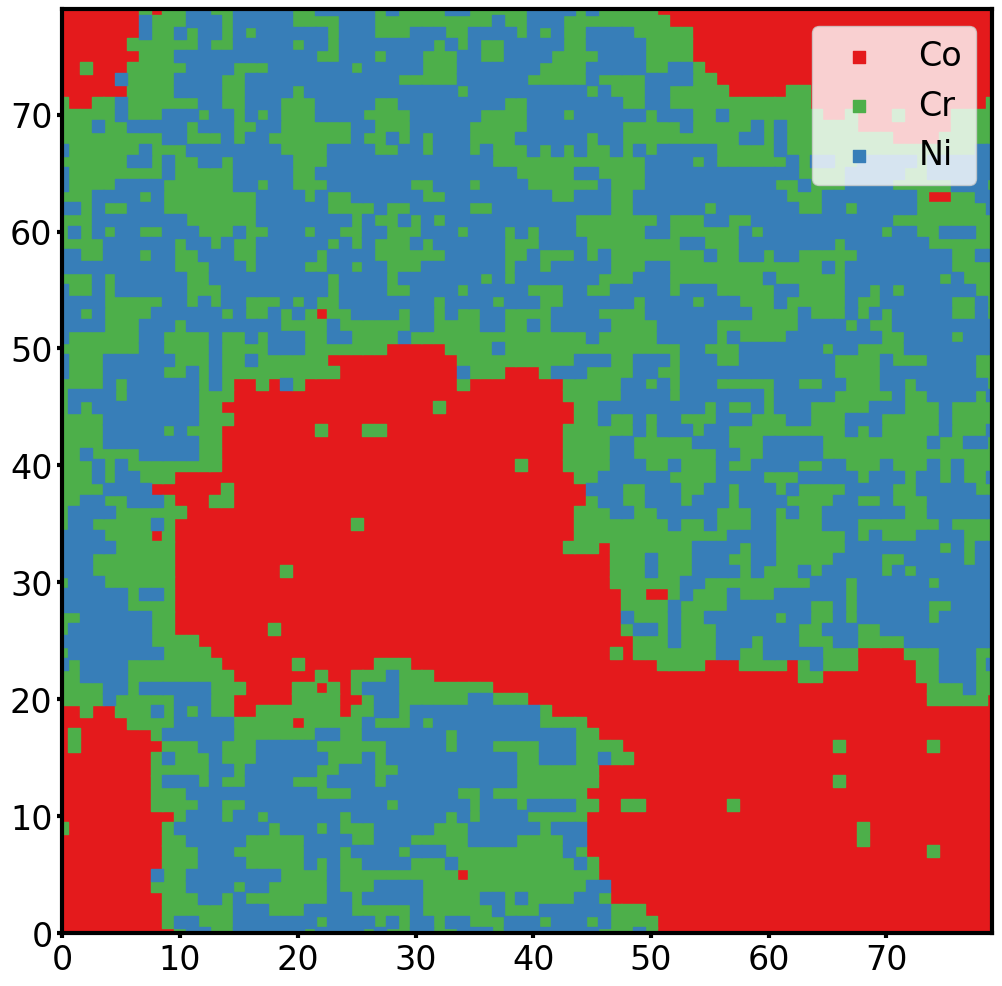

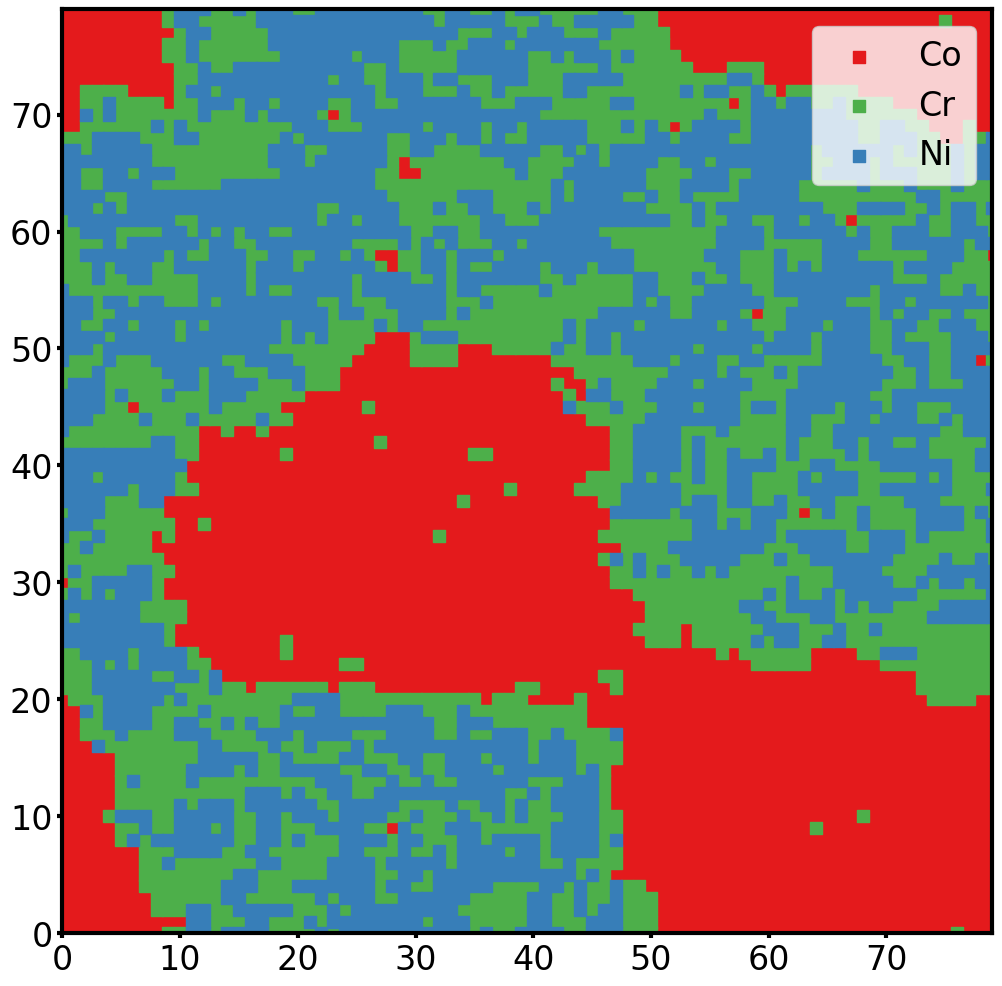

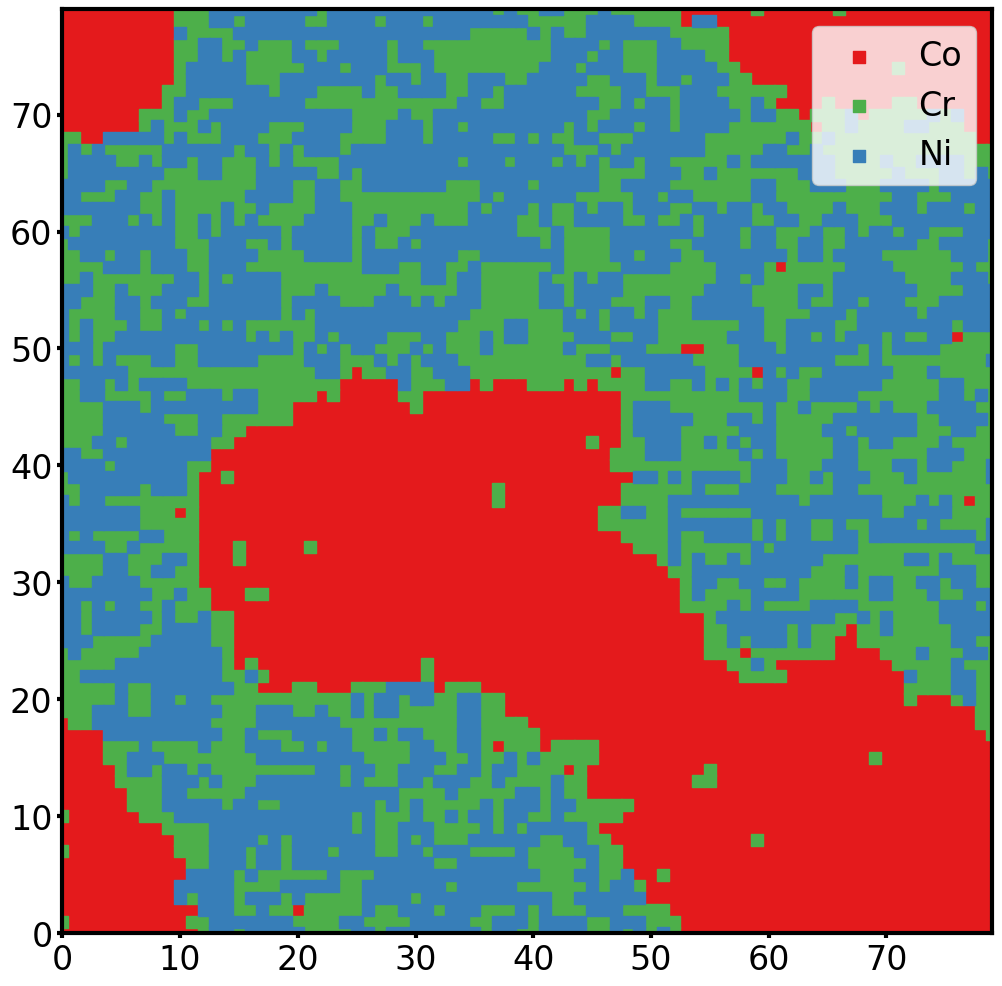

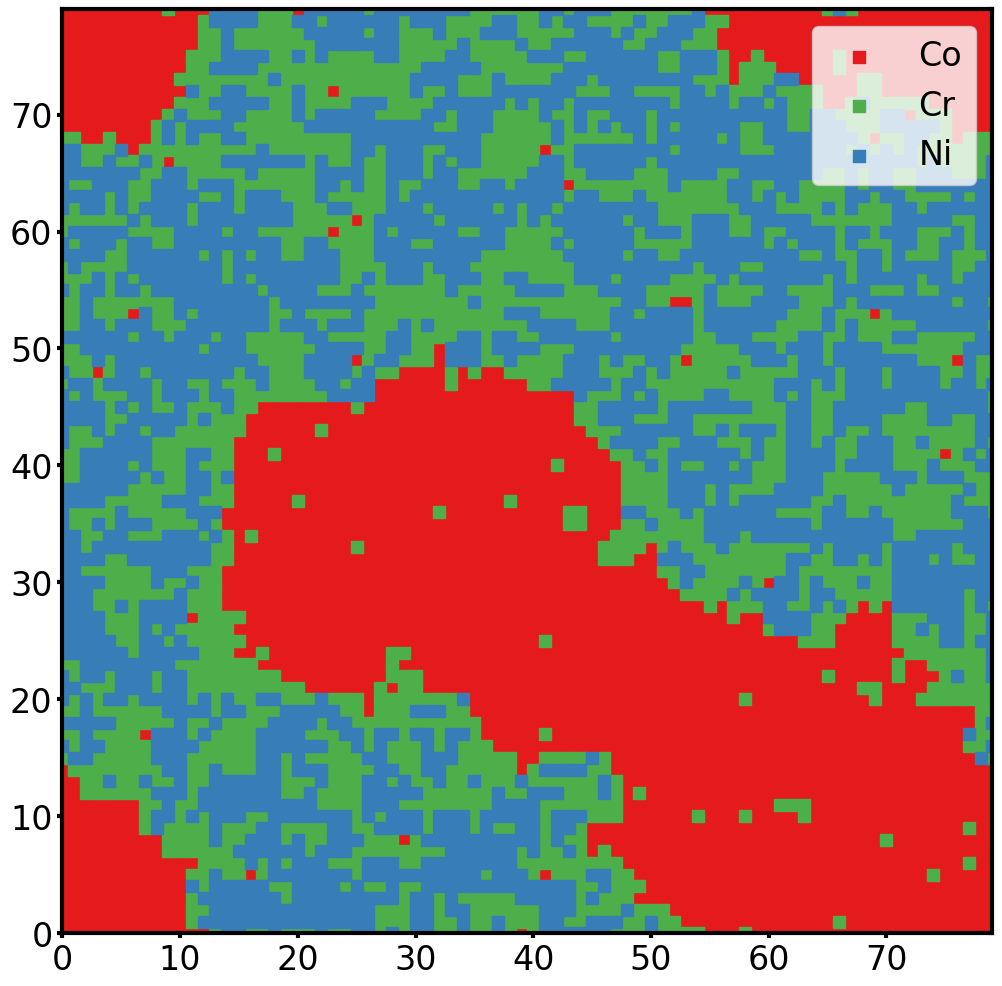

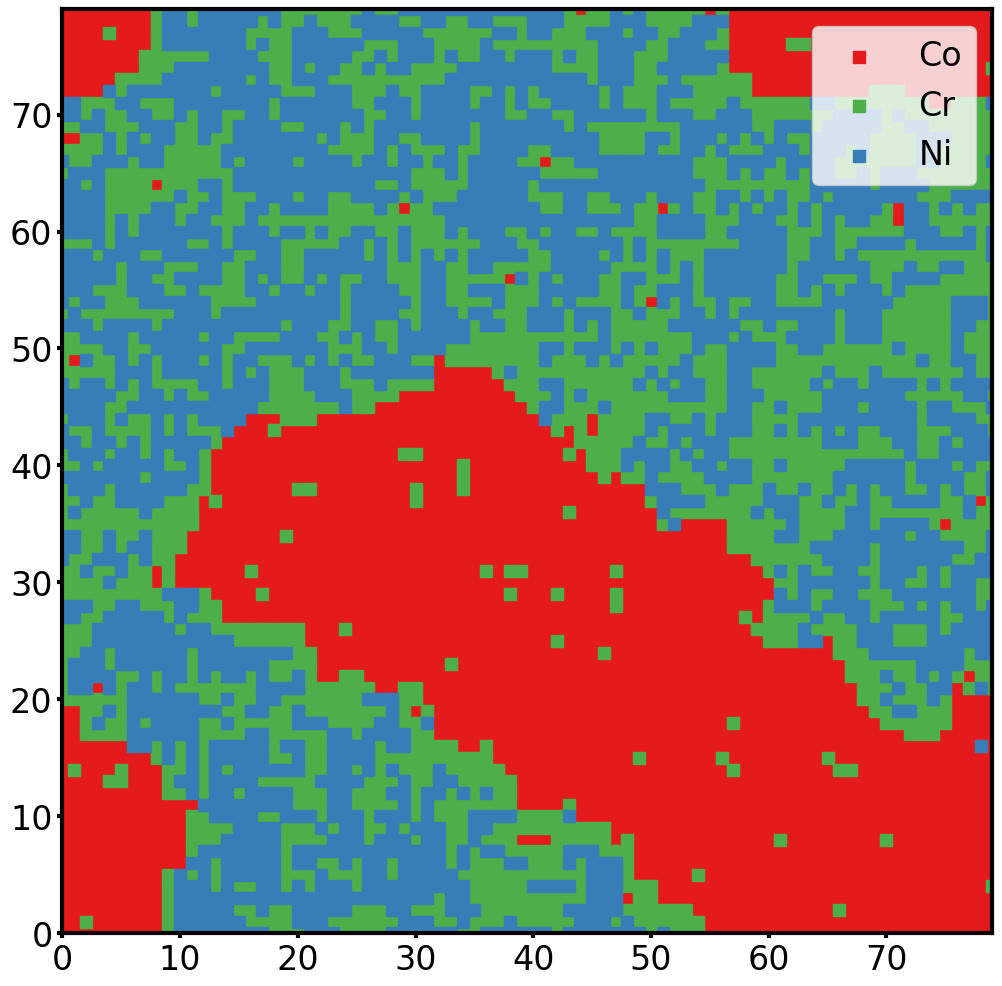

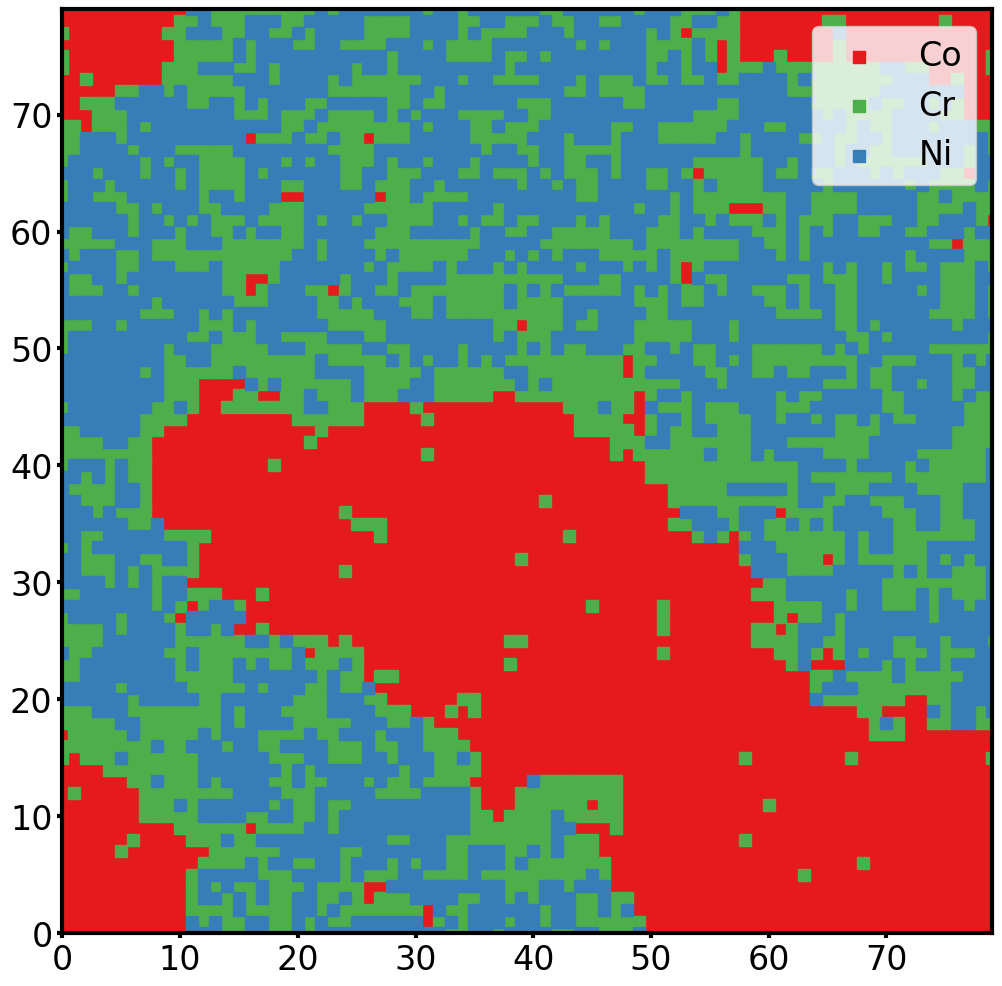

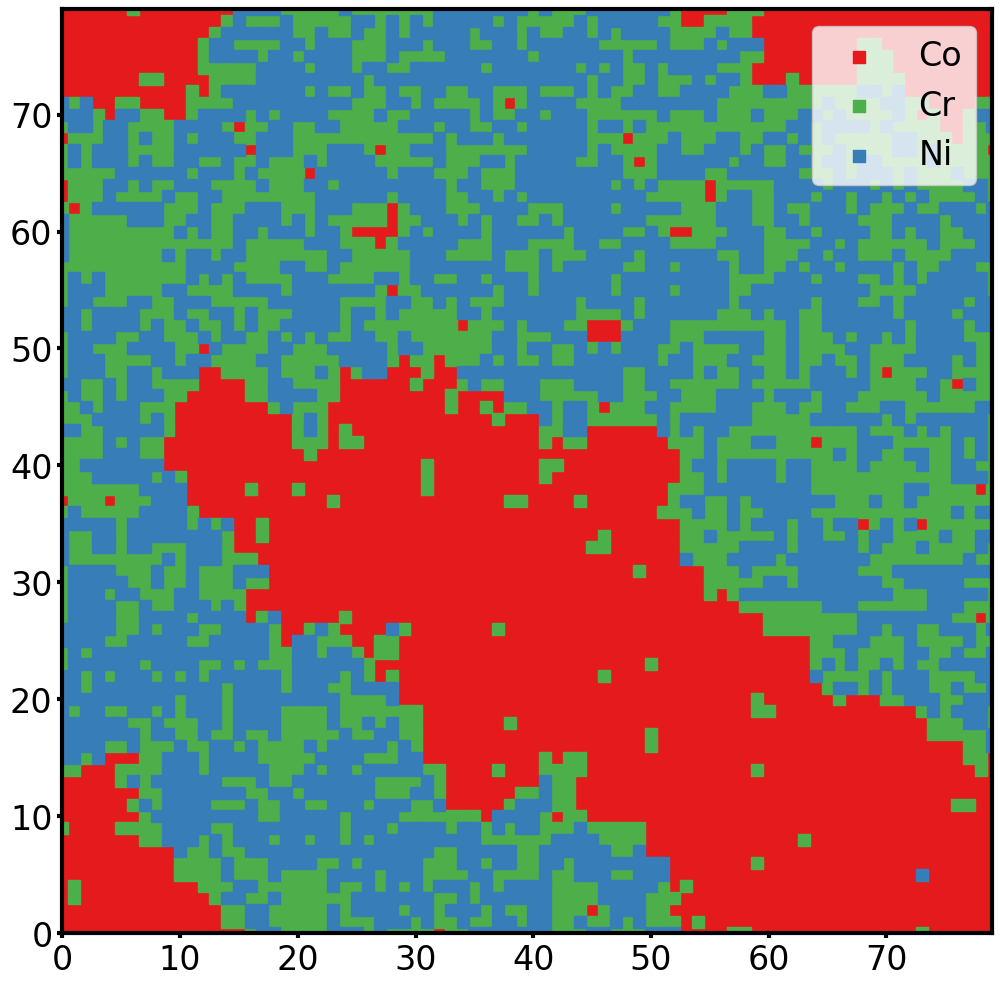

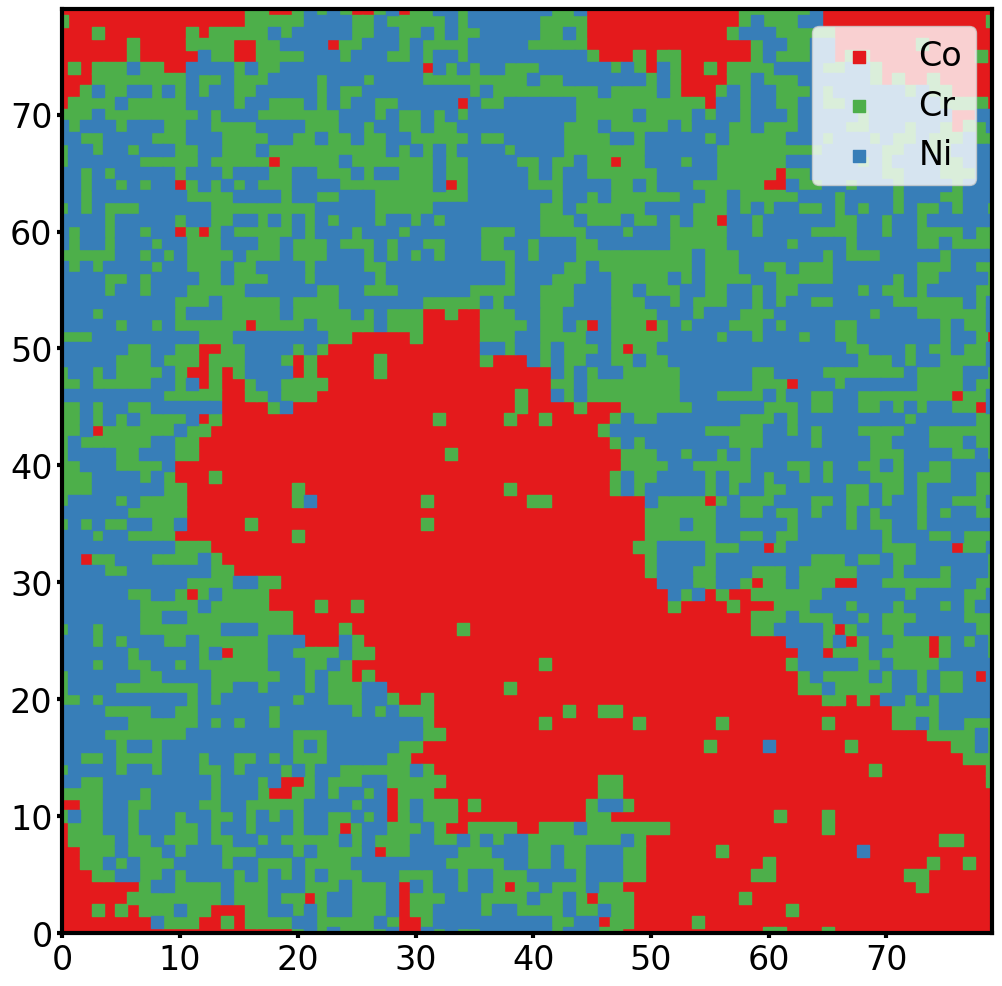

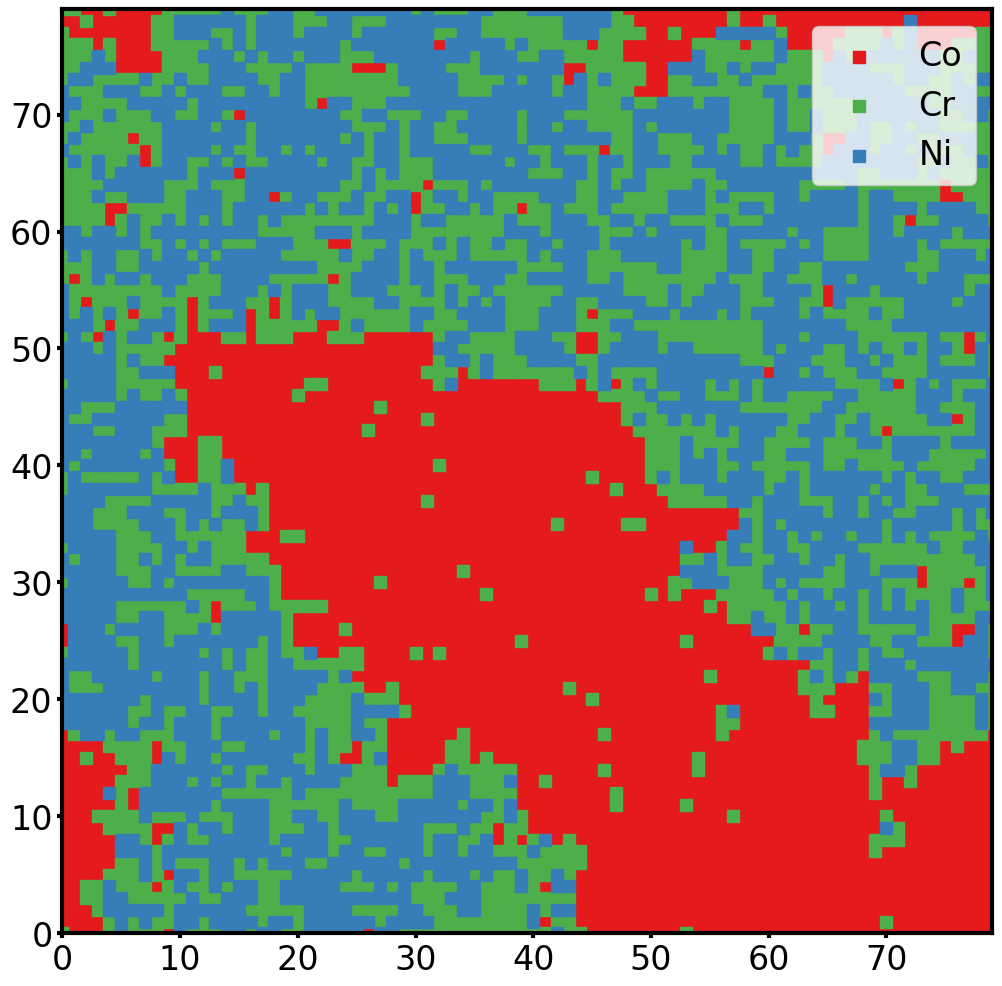

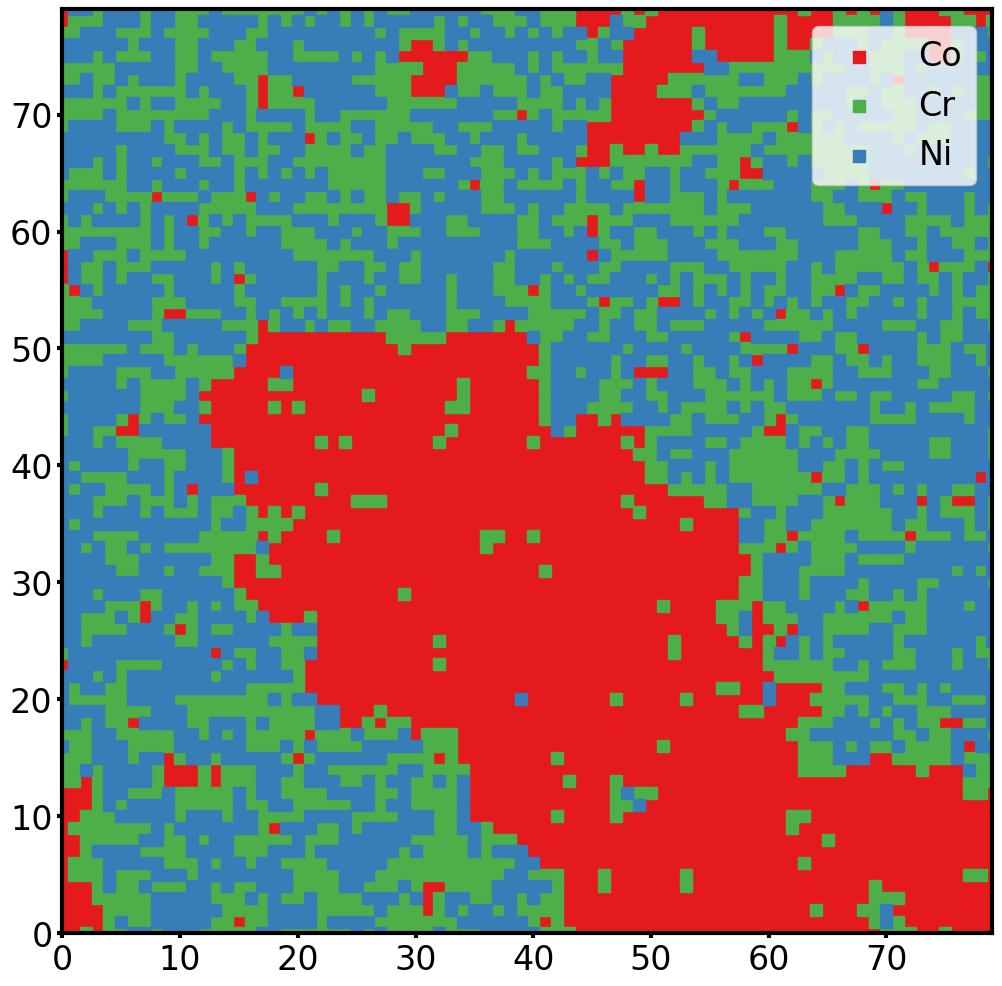

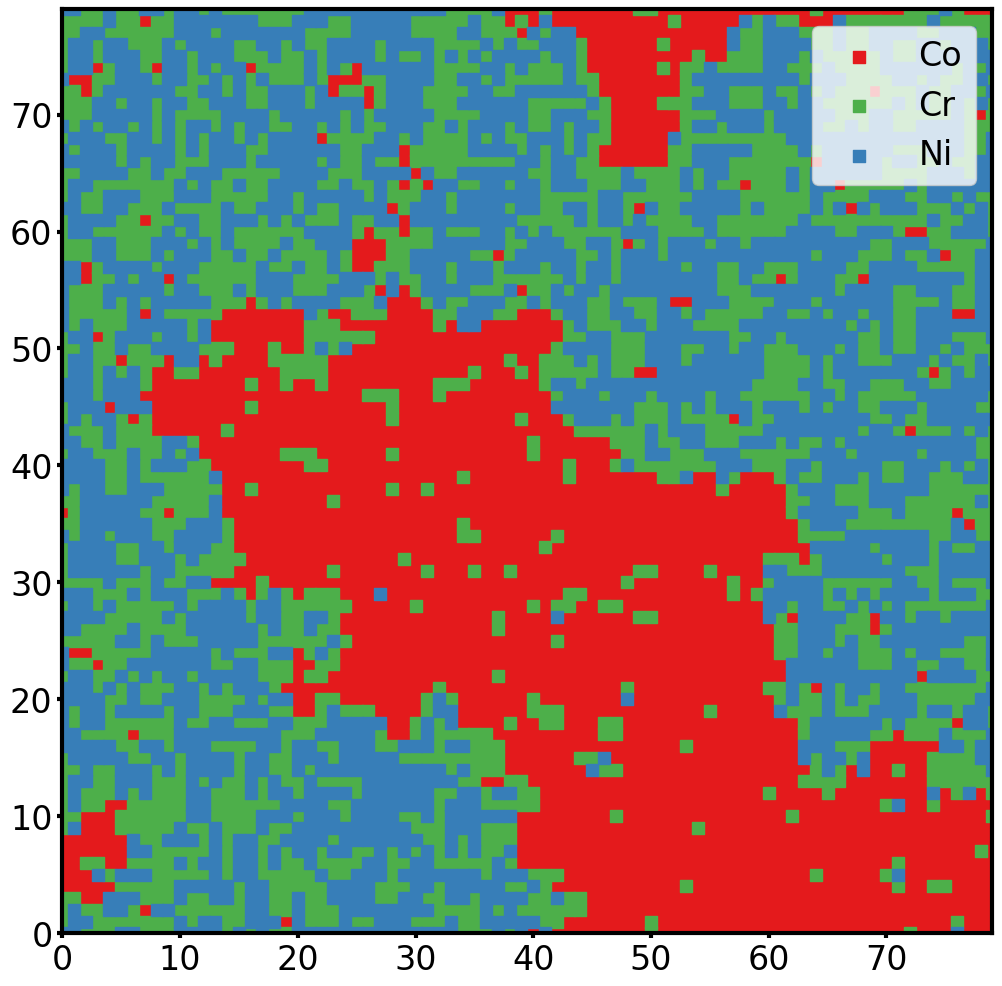

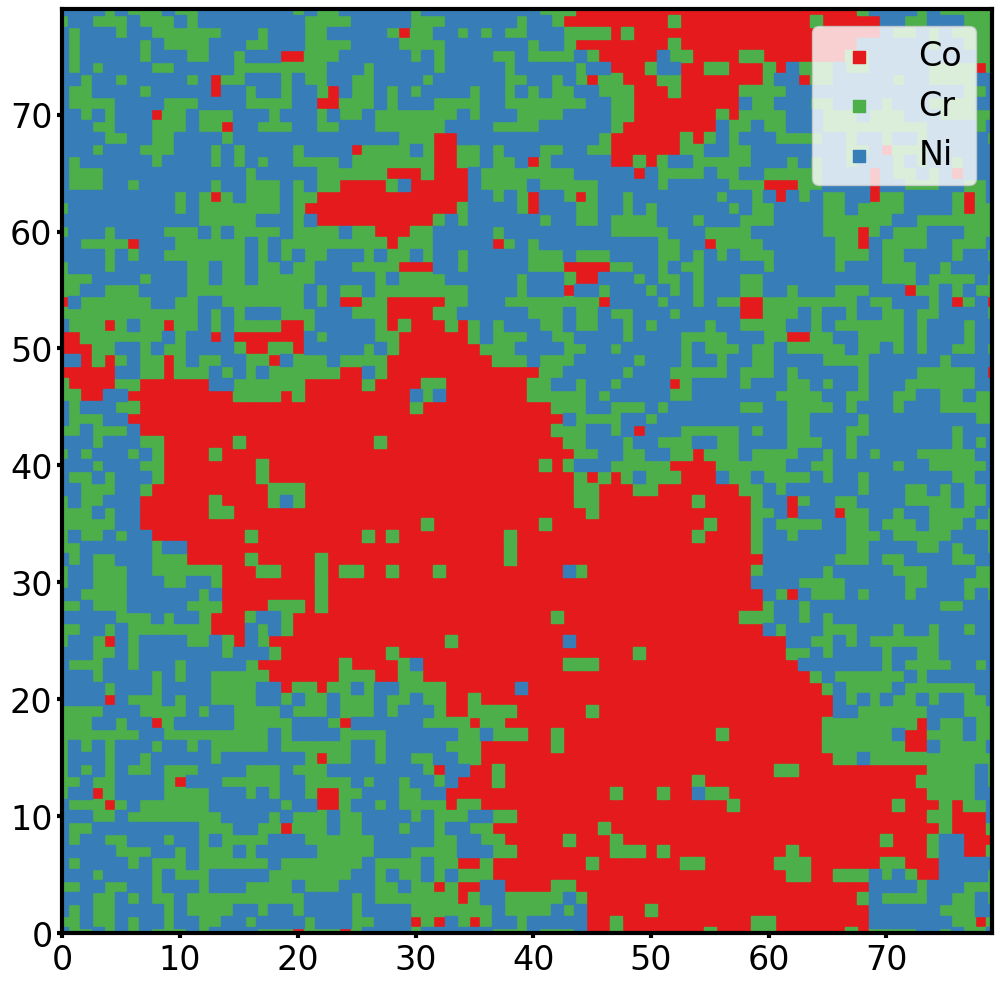

In [8]:
colors = ['#e41a1c', '#4daf4a', '#377eb8']


labels = ['Co', 'Cr', 'Ni']

for idx in range(len(temperatures)):
    plt.figure(figsize=(12, 12))
    for i in range(3):
        plt.scatter(*np.where(configs[idx] == i), color=colors[i], s=80, marker='s', alpha=1.0, label=labels[i])
        # plt.scatter(*np.where(config == i), edgecolors=None, color=colors[i], s=1, marker='o')

    # i=0
    # plt.scatter(*np.where(config == i), color=colors[i], s=5, marker='o', alpha=1.0, label=labels[i])
    plt.legend(fontsize=24, loc="upper right")
    plt.xlim(0,N-1)
    plt.ylim(0,N-1)
    plt.tick_params(axis='both', which='major', labelsize=24, width=3)
    for spine in plt.gca().spines.values():
        spine.set_linewidth(3)
    plt.savefig(f"Fig2/config_{temperatures[idx]:04}K_test.png")
    plt.show()